# Modelling Notebook

This notebook focuses on building and evaluating predictive models to estimate the likelihood of a heart attack based on patient data. Using the insights gained from the exploratory data analysis (EDA) notebook, we will:

Load the original dataset(s) again.
Re-apply the cleaning and preprocessing steps identified during EDA (removing duplicates, handling missing values if any, and performing basic feature transformations).
Prepare the data for modeling by encoding categorical variables and splitting into training and test sets.
Build and evaluate a baseline model (Logistic Regression), followed by more advanced models (Random Forest, XGBoost).
Use hyperparameter tuning to optimize model performance.
Compare model results and interpret the findings.
Our goal is to determine which model and features most effectively predict the target (heart attack likelihood), potentially informing clinical decision-making and resource allocation.

## Data Loading and Preparation

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# For now, we assume the datasets are in the same directory as the notebook.
# Adjust the paths if necessary.
heart_data = pd.read_csv('datasets/heart.csv')
o2_data = pd.read_csv('datasets/o2Saturation.csv')  # Might not be used if we couldn't integrate it meaningfully

# Display a quick summary
print("Heart Data Shape:", heart_data.shape)
print("O2 Data Shape:", o2_data.shape)

# Preview the heart dataset
print("\nHeart Data Preview:")
display(heart_data.head())

# Quick info on heart data
print("Heart Data Info:")
display(heart_data.info())


Heart Data Shape: (303, 14)
O2 Data Shape: (3585, 1)

Heart Data Preview:


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Heart Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


None

## Data Cleaning

In [34]:
# Remove duplicate rows from heart_data if any
heart_data_cleaned = heart_data.drop_duplicates()
print("Heart Data Shape after removing duplicates:", heart_data_cleaned.shape)

# Check for missing values again, though EDA indicated none
print("Missing Values in Heart Data:")
print(heart_data_cleaned.isnull().sum())

# Since o2_data didn't merge meaningfully during EDA, we may exclude it from modeling
# or we can choose to simply note it as unused. For now, let's set it aside:
o2_data_cleaned = o2_data.drop_duplicates()
print("O2 Data Shape after removing duplicates:", o2_data_cleaned.shape)

# We don't see missing values or severe issues from previous analysis,
# so no imputation or complex cleaning might be needed here.
# If required, we could do something like:
# imputer = SimpleImputer(strategy='mean')
# heart_data_cleaned['some_feature'] = imputer.fit_transform(heart_data_cleaned[['some_feature']])


Heart Data Shape after removing duplicates: (302, 14)
Missing Values in Heart Data:
age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64
O2 Data Shape after removing duplicates: (17, 1)


## Feature Preparation

In [35]:
# Separate features and target
X = heart_data_cleaned.drop('output', axis=1)
y = heart_data_cleaned['output']

# Identify categorical and numerical features
# Based on EDA, these columns are categorical: 
# sex, cp, fbs, restecg, exng, slp, caa, thall
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print("Categorical Features:", categorical_cols)
print("Numeric Features:", numeric_cols)

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print("Shape after one-hot encoding:", X_encoded.shape)


Categorical Features: ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
Numeric Features: ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
Shape after one-hot encoding: (302, 22)


## Train-Test Split

In [36]:
# Split into training and testing sets
# Use stratify=y to maintain proportional distribution of the target
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)


Training set size: (241, 22) (241,)
Test set size: (61, 22) (61,)


## Baseline Model: Logistic Regression

Logistic Regression Performance:
Accuracy: 0.8360655737704918
Precision: 0.8285714285714286
Recall: 0.8787878787878788
F1-Score: 0.8529411764705882

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



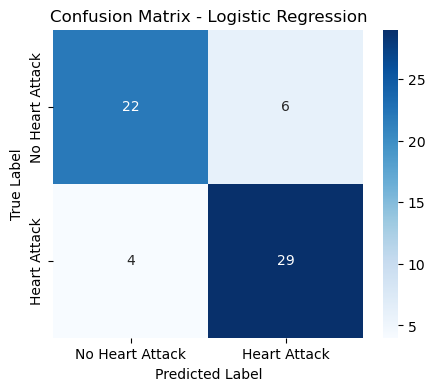

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Instantiate and fit logistic regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict on test set
y_pred_logreg = logreg.predict(X_test)

# Evaluate
acc_logreg = accuracy_score(y_test, y_pred_logreg)
prec_logreg = precision_score(y_test, y_pred_logreg)
rec_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

print("Logistic Regression Performance:")
print("Accuracy:", acc_logreg)
print("Precision:", prec_logreg)
print("Recall:", rec_logreg)
print("F1-Score:", f1_logreg)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Heart Attack","Heart Attack"], yticklabels=["No Heart Attack","Heart Attack"])
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


## Random Forest Model

Random Forest Performance:
Accuracy: 0.7377049180327869
Precision: 0.7297297297297297
Recall: 0.8181818181818182
F1-Score: 0.7714285714285715

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        28
           1       0.73      0.82      0.77        33

    accuracy                           0.74        61
   macro avg       0.74      0.73      0.73        61
weighted avg       0.74      0.74      0.74        61



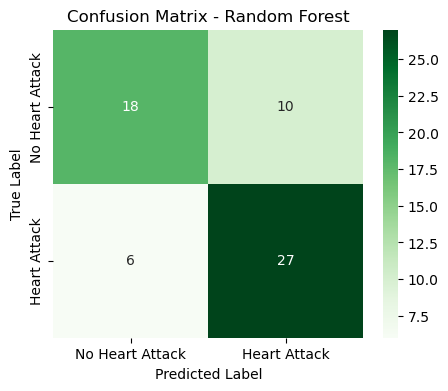

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate and fit random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Evaluate performance
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print("Accuracy:", acc_rf)
print("Precision:", prec_rf)
print("Recall:", rec_rf)
print("F1-Score:", f1_rf)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", xticklabels=["No Heart Attack","Heart Attack"], yticklabels=["No Heart Attack","Heart Attack"])
plt.title("Confusion Matrix - Random Forest")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


## XGBoost Model

XGBoost Performance (Default):
Accuracy: 0.6885245901639344
Precision: 0.6944444444444444
Recall: 0.7575757575757576
F1-Score: 0.7246376811594203

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        28
           1       0.69      0.76      0.72        33

    accuracy                           0.69        61
   macro avg       0.69      0.68      0.68        61
weighted avg       0.69      0.69      0.69        61



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:47:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


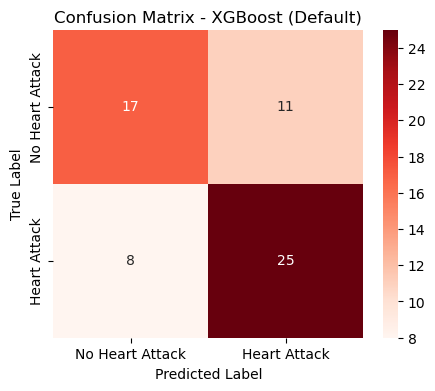

In [41]:
!pip install xgboost  # Uncomment if xgboost is not installed in your environment
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Initial XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

# Evaluate performance
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("XGBoost Performance (Default):")
print("Accuracy:", acc_xgb)
print("Precision:", prec_xgb)
print("Recall:", rec_xgb)
print("F1-Score:", f1_xgb)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Reds", xticklabels=["No Heart Attack","Heart Attack"], yticklabels=["No Heart Attack","Heart Attack"])
plt.title("Confusion Matrix - XGBoost (Default)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


## Hyperparameter Tuning for XGBoost

In [42]:
# Define a parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(xgb_grid, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score (Train CV):", grid_search.best_score_)

# Retrain using best parameters
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

acc_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
prec_best_xgb = precision_score(y_test, y_pred_best_xgb)
rec_best_xgb = recall_score(y_test, y_pred_best_xgb)
f1_best_xgb = f1_score(y_test, y_pred_best_xgb)

print("XGBoost (Tuned) Performance:")
print("Accuracy:", acc_best_xgb)
print("Precision:", prec_best_xgb)
print("Recall:", rec_best_xgb)
print("F1-Score:", f1_best_xgb)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb))


Fitting 5 folds for each of 108 candidates, totalling 540 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
Best F1 Score (Train CV): 0.8367881241565452
XGBoost (Tuned) Performance:
Accuracy: 0.7213114754098361
Precision: 0.7105263157894737
Recall: 0.8181818181818182
F1-Score: 0.7605633802816901

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        28
           1       0.71      0.82      0.76        33

    accuracy                           0.72        61
   macro avg       0.72      0.71      0.71        61
weighted avg       0.72      0.72      0.72        61



/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

## Model Comparison

In [26]:
# Compile results into a DataFrame
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost (Default)', 'XGBoost (Tuned)'],
    'Accuracy': [acc_logreg, acc_rf, acc_xgb, acc_best_xgb],
    'Precision': [prec_logreg, prec_rf, prec_xgb, prec_best_xgb],
    'Recall': [rec_logreg, rec_rf, rec_xgb, rec_best_xgb],
    'F1-Score': [f1_logreg, f1_rf, f1_xgb, f1_best_xgb]
})

display(results)

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.836066,0.828571,0.878788,0.852941
1,Random Forest,0.737705,0.729730,0.818182,0.771429
2,XGBoost (Default),0.688525,0.694444,0.757576,0.724638
3,XGBoost (Tuned),0.721311,0.710526,0.818182,0.760563


## Getting Predicted Probabilities and Plots

In [28]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get predicted probabilities for each model
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# If you haven't defined these before, define the hard predictions as well
y_pred_logreg = logreg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

# Display classification reports for reference
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        28
           1       0.83      0.88      0.85        33

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69        28
           1       0.73      0.82      0.77        33

    accuracy                           0.74        61
   macro avg       0.74      0.73      0.73        61
weighted avg       0.74      0.74      0.74        61

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64        28
           1       0.69      0.76      0.72        33

    accuracy                           0.69        61
   macro avg     

## ROC Curves

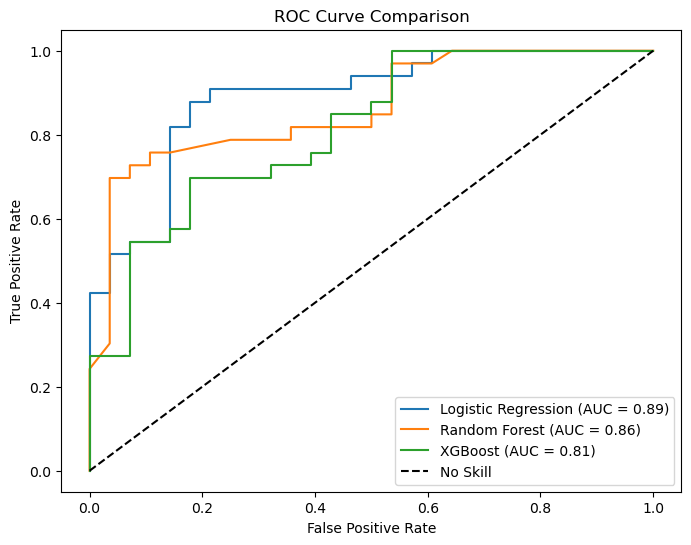

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {auc_logreg:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")
plt.plot([0,1],[0,1],'k--', label="No Skill")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()



Precision-Recall Curves

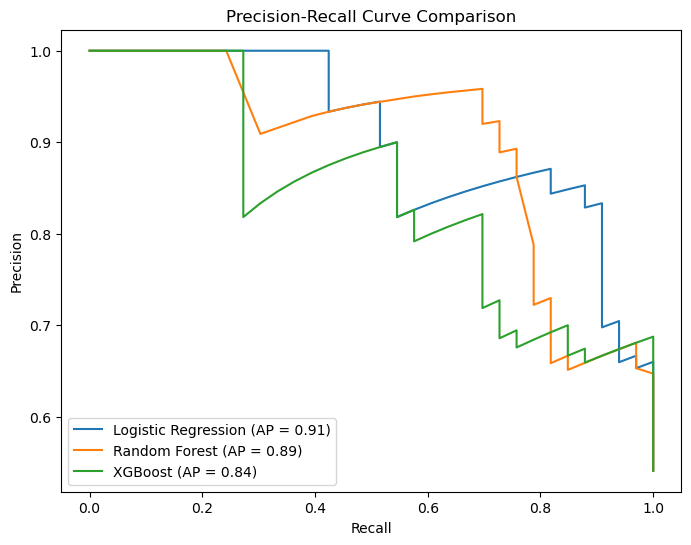

In [30]:
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_prob_logreg)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)

aps_logreg = average_precision_score(y_test, y_prob_logreg)
aps_rf = average_precision_score(y_test, y_prob_rf)
aps_xgb = average_precision_score(y_test, y_prob_xgb)

plt.figure(figsize=(8,6))
plt.plot(recall_logreg, precision_logreg, label=f"Logistic Regression (AP = {aps_logreg:.2f})")
plt.plot(recall_rf, precision_rf, label=f"Random Forest (AP = {aps_rf:.2f})")
plt.plot(recall_xgb, precision_xgb, label=f"XGBoost (AP = {aps_xgb:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()

## Feature Importance (for Tree-Based Models)

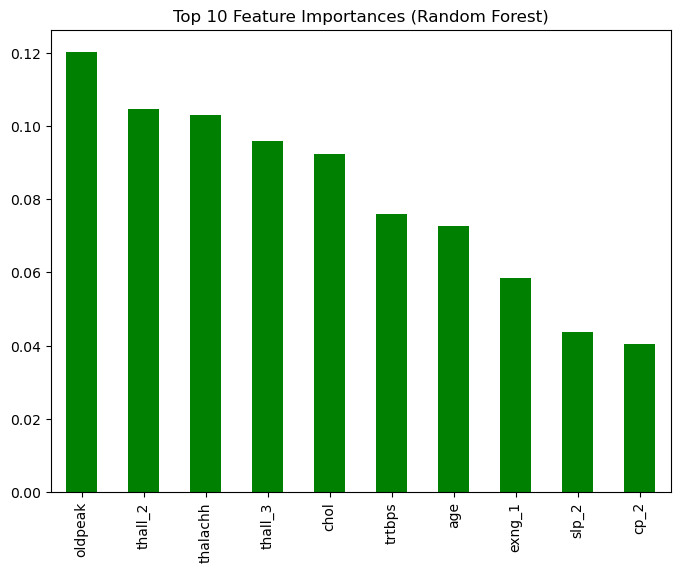

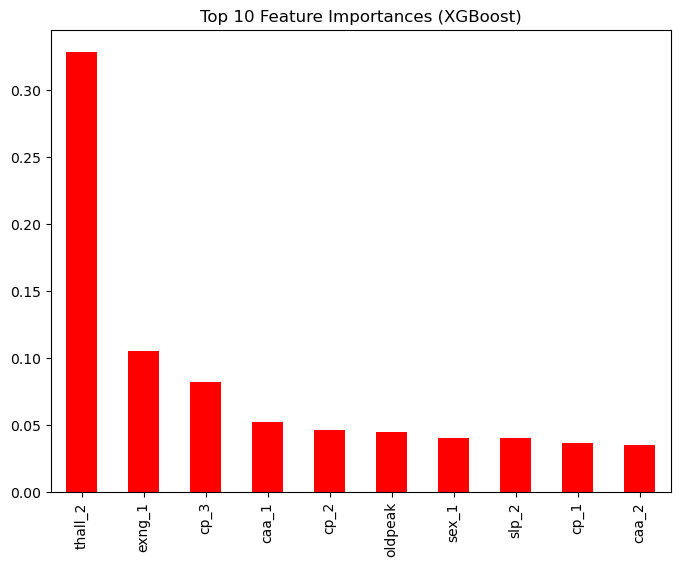

In [32]:
# Random Forest Feature Importances
importances_rf = rf.feature_importances_
feat_imp_rf = pd.Series(importances_rf, index=X_test.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp_rf.head(10).plot(kind='bar', color='green')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

# XGBoost Feature Importances
importances_xgb = xgb.feature_importances_
feat_imp_xgb = pd.Series(importances_xgb, index=X_test.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp_xgb.head(10).plot(kind='bar', color='red')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.show()
